In [1]:
import os
import glob
import sv as SV
import numpy as np 
from scipy.stats import binned_statistic

import healpy as hp

import fitsio

import astropy.io.fits as fits
import astropy.table as atable
from astropy import units as u
from astropy.coordinates import SkyCoord

In [2]:
from desitarget import cuts as desi_cuts
from desitarget.targetmask import bgs_mask 
from desitarget.geomask import imaging_mask
from desiutil.plots import plot_sky_circles

In [3]:
# -- plotting -- 
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
from matplotlib.legend_handler import HandlerPatch
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
dat_dir = '/global/cscratch1/sd/chahah/bgs-cmxsv/sv-paper/'

In [5]:
dir_randoms = '/project/projectdirs/desi/target/catalogs/dr9/0.49.0/randoms/resolve/'
Nrandom = 3
for i in range(Nrandom):
    ran = fitsio.read(os.path.join(dir_randoms, 'randoms-1-%i.fits' % i), columns=['RA', 'DEC', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'MASKBITS'], upper=True, ext=1)
    if i == 0: 
        rans = ran
    else:
        rans = np.concatenate([rans, ran])

In [6]:
rand = atable.Table(rans)

In [7]:
def get_radec_mw(ra, dec, org):
    # convert radec for mollwide
    ra          = np.remainder(ra+360-org, 360) # shift ra values
    ra[ra>180] -= 360    # scale conversion to [-180, 180]
    ra          =- ra    # reverse the scale: East to the left
    return np.radians(ra),np.radians(dec)

In [8]:
fpix = '/global/cfs/cdirs/desi/target/catalogs/dr9/1.1.1/pixweight/main/resolve/bright/pixweight-1-bright.fits'

hdr          = fits.getheader(fpix,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

hdu = fits.open(fpix)
pix_data = atable.Table(hdu[1].data)

pix_data['log10_STARDENS'] = np.log10(pix_data['STARDENS'])
for band in ['G', 'R', 'Z']: 
    pix_data['_GALDEPTH_%s' % band] = 22.5 - 2.5 * np.log10(5./np.sqrt(pix_data['GALDEPTH_%s' % band]))

<ipython-input-8-38d879117ded>:11: RuntimeWarning: divide by zero encountered in log10
  pix_data['log10_STARDENS'] = np.log10(pix_data['STARDENS'])
<ipython-input-8-38d879117ded>:13: RuntimeWarning: invalid value encountered in sqrt
  pix_data['_GALDEPTH_%s' % band] = 22.5 - 2.5 * np.log10(5./np.sqrt(pix_data['GALDEPTH_%s' % band]))
<ipython-input-8-38d879117ded>:13: RuntimeWarning: divide by zero encountered in true_divide
  pix_data['_GALDEPTH_%s' % band] = 22.5 - 2.5 * np.log10(5./np.sqrt(pix_data['GALDEPTH_%s' % band]))


In [49]:
pix_data['_PSFDEPTH_W1'] = 22.5 - 2.5 * np.log10(5./np.sqrt(pix_data['PSFDEPTH_W1']))
pix_data['_PSFDEPTH_W2'] = 22.5 - 2.5 * np.log10(5./np.sqrt(pix_data['PSFDEPTH_W2']))

<ipython-input-49-b6b1385e1f9f>:1: RuntimeWarning: invalid value encountered in sqrt
  pix_data['_PSFDEPTH_W1'] = 22.5 - 2.5 * np.log10(5./np.sqrt(pix_data['PSFDEPTH_W1']))
<ipython-input-49-b6b1385e1f9f>:2: RuntimeWarning: invalid value encountered in sqrt
  pix_data['_PSFDEPTH_W2'] = 22.5 - 2.5 * np.log10(5./np.sqrt(pix_data['PSFDEPTH_W2']))


In [9]:
nside, nest, npix, pixarea

(256, True, 786432, 0.052455852825697924)

In [10]:
def get_isdes(ra, dec):
    hdu = fits.open('/global/cscratch1/sd/raichoor/desits/des_hpmask.fits')
    nside, nest = hdu[1].header['HPXNSIDE'], hdu[1].header['HPXNEST']
    hppix = hp.ang2pix(nside,(90.-dec)*np.pi/180.,ra*np.pi/180.,nest=nest)
    isdes = np.zeros(len(ra),dtype=bool)
    isdes[np.in1d(hppix, hdu[1].data['hppix'])] = True
    return isdes

def get_isdesi(ra, dec, nest=True, tiledir='/global/cscratch1/sd/raichoor/'):
    radius   = 1.6 # degree
    tmpnside = 16
    tmpnpix  = hp.nside2npix(tmpnside)
    # first reading desi tiles, inside desi footprint (~14k deg2)
    hdu  = fits.open(tiledir+'desi-tiles-viewer.fits')
    data = hdu[1].data
    keep = (data['in_desi']==1)
    data = data[keep]
    tra,tdec = data['ra'],data['dec']
    # get hppix inside desi tiles
    theta,phi  = hp.pix2ang(tmpnside,np.arange(tmpnpix),nest=nest)
    hpra,hpdec = 180./np.pi*phi,90.-180./np.pi*theta
    hpindesi   = np.zeros(tmpnpix,dtype=bool)
    _,ind,_,_,_= search_around(tra,tdec,hpra,hpdec,search_radius=1.6*3600, verbose=False)
    hpindesi[np.unique(ind)] = True
    ## small hack to recover few rejected pixels inside desi. Avoid holes if any
    tmp  = np.array([i for i in range(tmpnpix) 
                     if hpindesi[hp.get_all_neighbours(tmpnside,i,nest=nest)].sum()==8])
    hpindesi[tmp] = True
    ##
    pixkeep    = np.where(hpindesi)[0]
    # now compute the hppix for the tested positions
    pix  = hp.ang2pix(tmpnside,(90.-dec)*np.pi/180.,ra*np.pi/180.,nest=nest)
    keep = np.in1d(pix,pixkeep)
    return keep
    
def search_around(ra1, dec1, ra2, dec2, search_radius=1., verbose=True):

    ra1, dec1, ra2, dec2 = map(np.copy, [ra1, dec1, ra2, dec2])

    sky1 = SkyCoord(ra1*u.degree,dec1*u.degree, frame='icrs')
    sky2 = SkyCoord(ra2*u.degree,dec2*u.degree, frame='icrs')
    idx1, idx2, d2d, d3d = sky2.search_around_sky(sky1, seplimit=search_radius*u.arcsec)

    if verbose:
        print('%d nearby objects'%len(idx1))
    # convert distances to numpy array in arcsec
    d2d   = np.array(d2d.to(u.arcsec))
    d_ra  = (ra2[idx2]-ra1[idx1])*3600.    # in arcsec
    d_dec = (dec2[idx2]-dec1[idx1])*3600. # in arcsec
    ##### Convert d_ra to actual arcsecs #####
    mask       = d_ra > 180*3600
    d_ra[mask] = d_ra[mask] - 360.*3600
    mask       = d_ra < -180*3600
    d_ra[mask] = d_ra[mask] + 360.*3600
    d_ra       = d_ra * np.cos(dec1[idx1]/180*np.pi)
    ##########################################

    return idx1, idx2, d2d, d_ra, d_dec

In [11]:
# get coordinates of healpixels
theta, phi = hp.pix2ang(nside,np.arange(npix), nest=nest)
pix_data['RA']  = 180. / np.pi * phi
pix_data['DEC'] = 90. - 180. / np.pi * theta

# galactic coordinates
c = SkyCoord(pix_data['RA'] * u.degree, pix_data['DEC'] * u.degree, frame='icrs')
pix_data['GALL'] = c.galactic.l.value
pix_data['GALB'] = c.galactic.b.value    

# north/south/des/decals
dec_resol_ns = 32.375

pix_data['IS_SOUTH'] = ((pix_data['GALB'] < 0) | ((pix_data['GALB'] > 0) & (pix_data['DEC'] < dec_resol_ns)))
pix_data['IS_NORTH'] = is_north = (pix_data['DEC'] > dec_resol_ns) & (pix_data['GALB'] > 0)

pix_data['IS_DES'] = get_isdes(pix_data['RA'], pix_data['DEC'])
pix_data['IS_DECALS'] = (pix_data['IS_SOUTH']) & (~pix_data['IS_DES'])
pix_data['IS_SOUTH_N'] = (pix_data['IS_SOUTH']) & (pix_data['GALB']>0)
pix_data['IS_SOUTH_S'] = (pix_data['IS_SOUTH']) & (pix_data['GALB']<0)

pix_data['IS_DESI'] = get_isdesi(pix_data['RA'], pix_data['DEC'])

In [12]:
ramw, decmw = get_radec_mw(pix_data['RA'], pix_data['DEC'], 120)

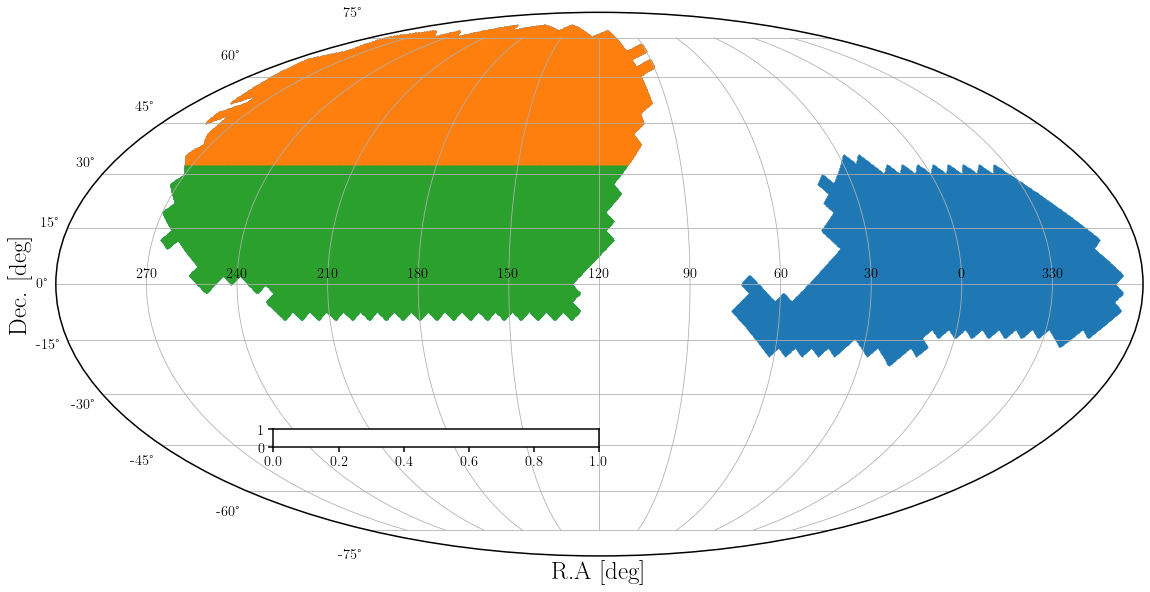

In [64]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0], projection='mollweide')

SC = ax.scatter(ramw[pix_data['IS_DESI']], decmw[pix_data['IS_DESI']], s=1, rasterized=True)
ax.scatter(ramw[pix_data['IS_DESI'] & pix_data['IS_NORTH']], decmw[pix_data['IS_DESI'] & pix_data['IS_NORTH']], s=1, rasterized=True)
ax.scatter(ramw[pix_data['IS_DESI'] & pix_data['IS_SOUTH_N']], decmw[pix_data['IS_DESI'] & pix_data['IS_SOUTH_N']], s=1, rasterized=True)


p  = ax.get_position().get_points().flatten()
cax= fig.add_axes([p[0]+0.2*(p[2]-p[0]),p[1]+0.2*(p[3]-p[1]),0.3*(p[2]-p[0]),0.025])

tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+120, 360)
ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
ax.set_xlabel('R.A [deg]', fontsize=25)
ax.set_ylabel('Dec. [deg]', fontsize=25)
ax.grid(True)

# calculate BGS area fraction for each healpixel using randoms

In [14]:
def apply_BGSmask_random(rand): 
    bgs = np.ones_like(rand['NOBS_G'], dtype='?')
    bgs &= (rand['NOBS_G'] >= 1) & (rand['NOBS_R'] >= 1) & (rand['NOBS_Z'] >= 1)
    bgs &= imaging_mask(rand['MASKBITS'], bgsmask=True)
    return rand[bgs]

In [15]:
rand = apply_BGSmask_random(rand)

In [16]:
rand['HPPIX'] = hp.ang2pix(nside, (90.-np.array(rand['DEC']))*np.pi/180.,np.array(rand['RA'])*np.pi/180.,nest=nest)

In [17]:
u_hp, u_hp_counts = np.unique(rand['HPPIX'], return_counts=True)

In [18]:
pix_data['BGS_FRAC_AREA'] = np.zeros(len(pix_data))
pix_data['BGS_FRAC_AREA'][u_hp] = u_hp_counts / (2500. * float(Nrandom)) / pixarea

In [19]:
area_all = pix_data['BGS_FRAC_AREA'].sum() * pixarea
print(area_all)

19555.418266666664


0.8565933239640451 1.1107753192056016


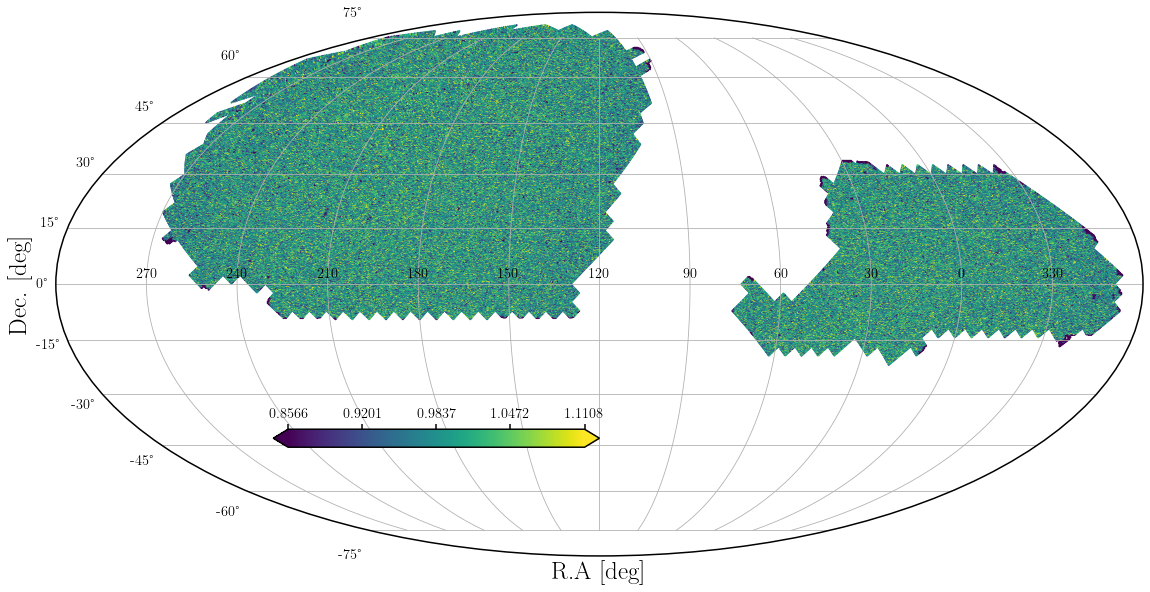

In [20]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0], projection='mollweide')

is_bgs = (pix_data['BGS_FRAC_AREA'] > 0.) & pix_data['IS_DESI']
cmin, cmax = np.quantile(pix_data['BGS_FRAC_AREA'][is_bgs], [0.01, 0.99])
print(cmin, cmax)

#SC = ax.scatter(ramw, decmw, s=1, c='k')#, c=pix_data['BGS_FRAC_AREA'][is_bgs], vmin=cmin, vmax=cmax, rasterized=True)
SC = ax.scatter(ramw[is_bgs], decmw[is_bgs], s=1, c=pix_data['BGS_FRAC_AREA'][is_bgs], vmin=cmin, vmax=cmax, rasterized=True)

p  = ax.get_position().get_points().flatten()
cax= fig.add_axes([p[0]+0.2*(p[2]-p[0]),p[1]+0.2*(p[3]-p[1]),0.3*(p[2]-p[0]),0.025])

cbarticks = np.linspace(cmin,cmax,5)
cbar_ylab = ['%.0f' % x for x in cbarticks]

cbar = plt.colorbar(SC, cax=cax, orientation='horizontal', ticklocation='top', extend='both', ticks=cbarticks)
#cbar.set_label(clab,fontweight='bold')
cbar.ax.set_yticklabels(cbar_ylab)

tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+120, 360)
ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
ax.set_xlabel('R.A [deg]', fontsize=25)
ax.set_ylabel('Dec. [deg]', fontsize=25)
ax.grid(True)

# read in target catalogs and calculate the number density in pixel

In [21]:
dir_targets = '/global/cfs/cdirs/desi/target/catalogs/dr9/1.1.1/targets/main/resolve/bright/'

targs = [] 
for ftarg in glob.glob(dir_targets+'*fits'): 
    targs.append(atable.Table.read(ftarg, hdu=1)['RA', 'DEC', 'BGS_TARGET'])
targs = atable.vstack(targs)

In [22]:
targs['HPPIX'] = hp.ang2pix(nside,(90.-np.array(targs['DEC'])) * np.pi/180., np.array(targs['RA'])*np.pi/180., nest=nest)

c = SkyCoord(targs['RA'], targs['DEC'], frame='icrs')
targs['GALB'] = c.galactic.b.value 
targs['GALL'] = c.galactic.l.value 

targs['IS_SOUTH'] = ((targs['GALB'] < 0) | ((targs['GALB'] > 0) & (targs['DEC'] < dec_resol_ns)))
targs['IS_NORTH'] = ((targs['DEC'] > dec_resol_ns) & (targs['GALB'] > 0))

In [23]:
# count up targets in healpixels
targs['BGS_BRIGHT'] = (targs['BGS_TARGET'] & bgs_mask['BGS_BRIGHT']) != 0 
targs['BGS_FAINT'] = (targs['BGS_TARGET'] & bgs_mask['BGS_FAINT']) != 0 

u_hp, u_hp_count = np.unique(targs['HPPIX'][targs['BGS_BRIGHT']], return_counts=True)
pix_data['N_BGS_BRIGHT'] = np.zeros(npix)
pix_data['N_BGS_BRIGHT'][u_hp] = u_hp_count

u_hp, u_hp_count = np.unique(targs['HPPIX'][targs['BGS_FAINT']], return_counts=True)
pix_data['N_BGS_FAINT'] = np.zeros(npix)
pix_data['N_BGS_FAINT'][u_hp] = u_hp_count

pix_data['N_BGS_ALL'] = pix_data['N_BGS_BRIGHT'] + pix_data['N_BGS_FAINT'] 

In [24]:
pix_data['density_BGS_BRIGHT'] = pix_data['N_BGS_BRIGHT'] / (pixarea * pix_data['BGS_FRAC_AREA'])
pix_data['density_BGS_FAINT'] = pix_data['N_BGS_FAINT'] / (pixarea * pix_data['BGS_FRAC_AREA'])
pix_data['density_BGS_ALL'] = pix_data['N_BGS_ALL'] / (pixarea * pix_data['BGS_FRAC_AREA'])

<ipython-input-24-0ae8d56d45c8>:1: RuntimeWarning: divide by zero encountered in true_divide
  pix_data['density_BGS_BRIGHT'] = pix_data['N_BGS_BRIGHT'] / (pixarea * pix_data['BGS_FRAC_AREA'])
<ipython-input-24-0ae8d56d45c8>:1: RuntimeWarning: invalid value encountered in true_divide
  pix_data['density_BGS_BRIGHT'] = pix_data['N_BGS_BRIGHT'] / (pixarea * pix_data['BGS_FRAC_AREA'])
<ipython-input-24-0ae8d56d45c8>:2: RuntimeWarning: divide by zero encountered in true_divide
  pix_data['density_BGS_FAINT'] = pix_data['N_BGS_FAINT'] / (pixarea * pix_data['BGS_FRAC_AREA'])
<ipython-input-24-0ae8d56d45c8>:2: RuntimeWarning: invalid value encountered in true_divide
  pix_data['density_BGS_FAINT'] = pix_data['N_BGS_FAINT'] / (pixarea * pix_data['BGS_FRAC_AREA'])
<ipython-input-24-0ae8d56d45c8>:3: RuntimeWarning: divide by zero encountered in true_divide
  pix_data['density_BGS_ALL'] = pix_data['N_BGS_ALL'] / (pixarea * pix_data['BGS_FRAC_AREA'])
<ipython-input-24-0ae8d56d45c8>:3: RuntimeWarni

In [25]:
all_exps = SV.info_exposures(release='everest')

In [26]:
in_bright = (all_exps['FAPRGRM'] == 'bgsmws') | (all_exps['FAPRGRM'] == 'bright')
print("%i exposures in BRIGHT" % np.sum(in_bright))

sv1_exps = all_exps[(all_exps['SURVEY'] == 'sv1') & in_bright]
sv3_exps = all_exps[(all_exps['SURVEY'] == 'sv3') & in_bright]
main_exps = all_exps[(all_exps['SURVEY'] == 'main') & in_bright]

print('%i SV1 BRIGHT exposure' % len(sv1_exps))
print('%i SV3 BRIGHT exposure' % len(sv3_exps))
print('%i MAIN BRIGHT exposure' % len(main_exps))

1418 exposures in BRIGHT
635 SV1 BRIGHT exposure
298 SV3 BRIGHT exposure
409 MAIN BRIGHT exposure


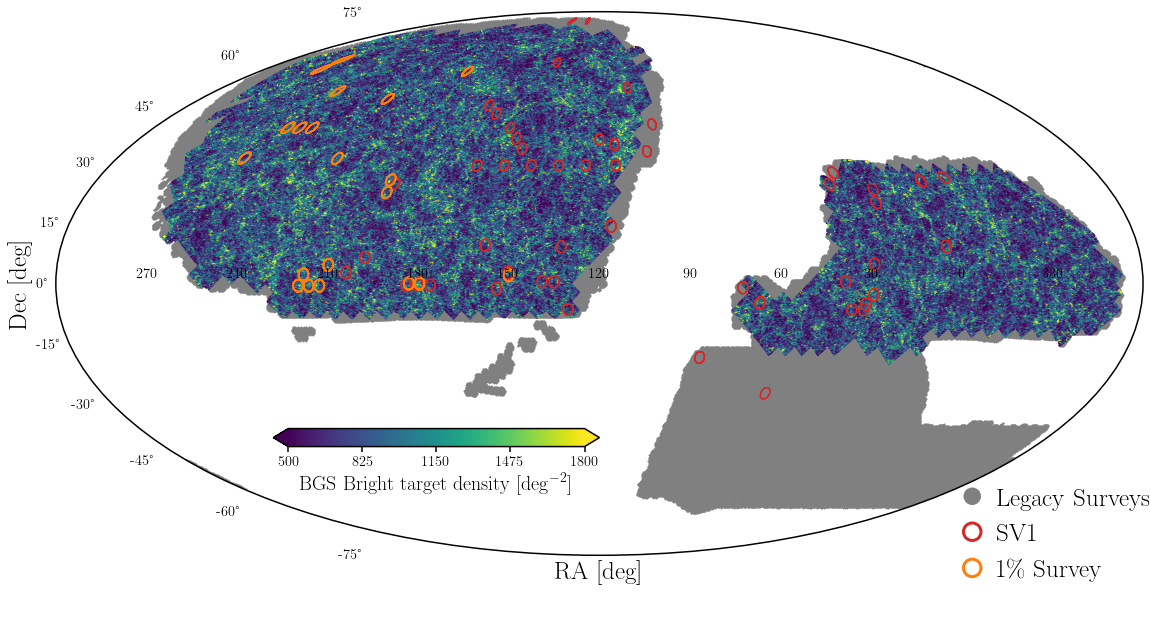

In [43]:
# mollweide
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0], projection='mollweide')

is_bgs = (pix_data['BGS_FRAC_AREA'] > 0.) & pix_data['IS_DESI']
#cmin, cmax = np.quantile(pix_data['density_BGS_BRIGHT'][is_bgs], [0.01, 0.99])
#print(cmin, cmax)
cmin, cmax = 500, 1800

ax.scatter(ramw[pix_data['BGS_FRAC_AREA'] > 0.], decmw[pix_data['BGS_FRAC_AREA'] > 0.], s=1, c='gray', rasterized=True)
SC = ax.scatter(ramw[is_bgs], decmw[is_bgs], s=1, c=pix_data['density_BGS_BRIGHT'][is_bgs], vmin=cmin, vmax=cmax, rasterized=True)

field_of_view = 3.2
sv1_ramw, sv1_decmw = get_radec_mw(sv1_exps['TILERA'], sv1_exps['TILEDEC'], 120)
dRA_sv1 = field_of_view / np.cos(np.radians(sv1_decmw))

for ra, dec, dra in zip(sv1_ramw, sv1_decmw, dRA_sv1):
    e = Ellipse((ra, dec), np.radians(dra), np.radians(field_of_view),
                facecolor='none', edgecolor='C3')
    ax.add_patch(e)

sv3_ramw, sv3_decmw = get_radec_mw(sv3_exps['TILERA'], sv3_exps['TILEDEC'], 120)
dRA_sv3 = field_of_view / np.cos(np.radians(sv3_decmw))

for ra, dec, dra in zip(sv3_ramw, sv3_decmw, dRA_sv3):
    e = Ellipse((ra, dec), np.radians(dra), np.radians(field_of_view),
                facecolor='none', edgecolor='C1')
    ax.add_patch(e)

p  = ax.get_position().get_points().flatten()
cax= fig.add_axes([p[0]+0.2*(p[2]-p[0]),p[1]+0.2*(p[3]-p[1]),0.3*(p[2]-p[0]),0.025])

cbarticks = np.linspace(cmin,cmax,5)
cbar_ylab = ['%.0f' % x for x in cbarticks]

cbar = plt.colorbar(SC, cax=cax, orientation='horizontal', ticklocation='bottom', extend='both', ticks=cbarticks)
cbar.set_label(r'BGS Bright target density [${\rm deg}^{-2}$]', fontsize=20)
cbar.ax.set_yticklabels(cbar_ylab)


tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+120, 360)
ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
ax.set_xlabel('RA [deg]', fontsize=25)
ax.set_ylabel('Dec [deg]', fontsize=25)

# legend for ellipses
colors = ["C3", "C1"]
texts = ["SV1 ", r"$1\%$ Survey"]
class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = patches.Ellipse(xy=center, width=height + xdescent,
                             height=height + ydescent)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

c = [patches.Circle((0.5, 0.5), 1, facecolor='gray', edgecolor='none', linewidth=3)] + [patches.Circle((0.5, 0.5), 1, facecolor='none', edgecolor=colors[i], linewidth=3) for i in range(len(texts))]
texts = ['Legacy Surveys'] + texts
fig.legend(c, texts, bbox_to_anchor=(0.815, 0.025), loc='lower right', 
           handler_map={patches.Circle: HandlerEllipse()}, fontsize=25, handletextpad=0)#.get_frame().set_facecolor('#00FFCC')
fig.savefig('figs/footprint.pdf', bbox_inches='tight')

In [53]:
np.nanquantile(pix_data['_PSFDEPTH_W2'], [0.01, 0.99])

array([20.59186094, 21.4335825 ])

In [83]:
is_bgs = (pix_data['BGS_FRAC_AREA'] > 0.) & pix_data['IS_DESI']
is_bassmzls = is_bgs & pix_data['IS_NORTH']
is_decals_n = is_bgs & pix_data['IS_SOUTH_N']
is_decals_s = is_bgs & pix_data['IS_SOUTH_S']

In [74]:
mean_densities = []
for ii, sample in enumerate(['BRIGHT', 'FAINT', 'ALL']): 
    mean_densities.append(np.sum(pix_data['N_BGS_%s' % sample][is_bgs]) / np.sum(pixarea * pix_data['BGS_FRAC_AREA'][is_bgs]))
print(mean_densities)

[864.2835661479479, 532.7706971727894, 1397.0542633207372]


In [84]:
for footprint in [is_bassmzls, is_decals_n, is_decals_s]: 
    _mean_densities = [] 
    for ii, sample in enumerate(['BRIGHT', 'FAINT', 'ALL']): 
        _mean_densities.append(np.sum(pix_data['N_BGS_%s' % sample][footprint]) / np.sum(pixarea * pix_data['BGS_FRAC_AREA'][footprint]))
    print(_mean_densities)

[865.3809688854441, 531.3711633521606, 1396.7521322376047]
[879.994088126593, 543.3589875159183, 1423.3530756425114]
[844.0348350944556, 521.3455053230315, 1365.380340417487]


864.2835661479479
[29662. 51584. 38760. 33361. 23511. 17025. 13170. 10184.  8197.  6628.
  5577.  4884.  4208.  3710.  3202.  2709.  1883.  1872.  1619.  1232.]
532.7706971727894
[29662. 51584. 38760. 33361. 23511. 17025. 13170. 10184.  8197.  6628.
  5577.  4884.  4208.  3710.  3202.  2709.  1883.  1872.  1619.  1232.]
864.2835661479479
[20197. 24077. 26129. 25591. 22886. 19912. 17944. 15713. 13810. 11700.
  9743.  8243.  7117.  5893.  5022.  4234.  3694.  3141.  2844.  2440.]
532.7706971727894
[20197. 24077. 26129. 25591. 22886. 19912. 17944. 15713. 13810. 11700.
  9743.  8243.  7117.  5893.  5022.  4234.  3694.  3141.  2844.  2440.]
864.2835661479479
[17844. 24849. 29362. 29772. 27499. 24321. 20882. 17522. 14954. 12724.
 10418.  8119.  6486.  4594.  3236.  2084.  1392.   768.   402.   269.]
532.7706971727894
[17844. 24849. 29362. 29772. 27499. 24321. 20882. 17522. 14954. 12724.
 10418.  8119.  6486.  4594.  3236.  2084.  1392.   768.   402.   269.]
864.2835661479479
[27832. 30171. 3

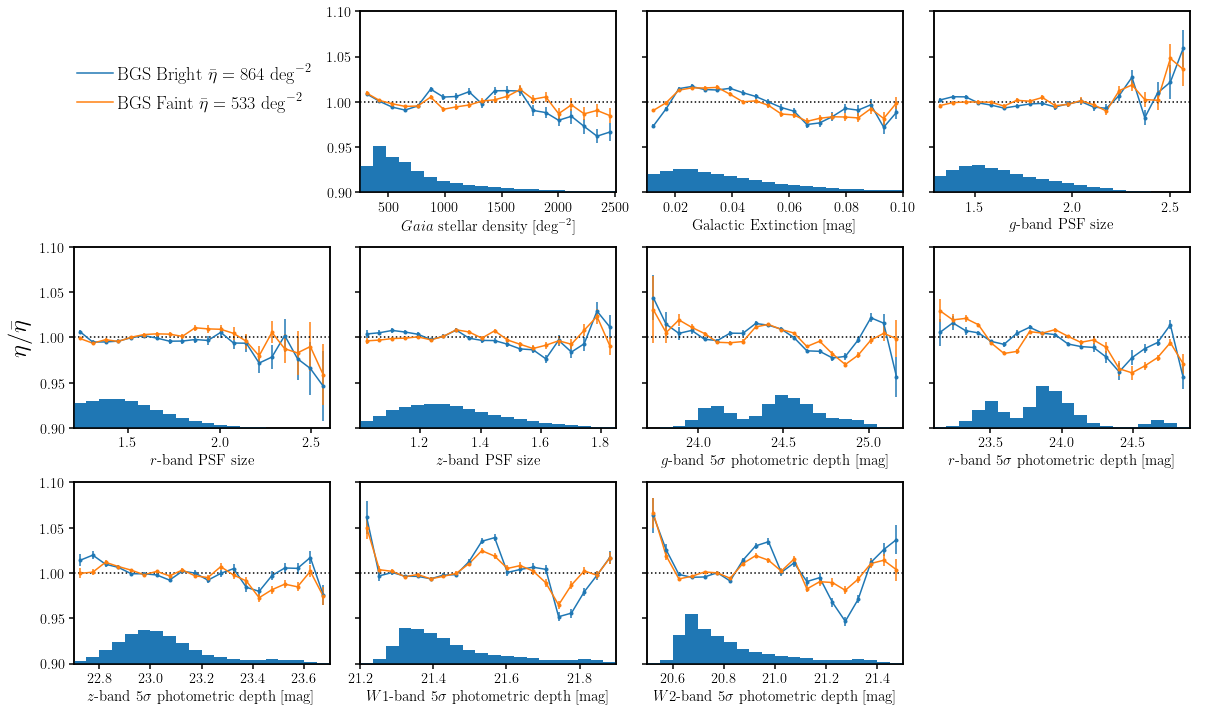

In [94]:
fig = plt.figure(figsize=(20,12))

systematics = ['STARDENS', 'EBV', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', '_GALDEPTH_G', '_GALDEPTH_R', '_GALDEPTH_Z', '_PSFDEPTH_W1', '_PSFDEPTH_W2']
xlabels = [r'$Gaia$ stellar density [${\rm deg}^{-2}$]', 'Galactic Extinction [mag]', '$g$-band PSF size', '$r$-band PSF size', '$z$-band PSF size', 
           '$g$-band $5\sigma$ photometric depth [mag]', '$r$-band $5\sigma$ photometric depth [mag]', '$z$-band $5\sigma$ photometric depth [mag]', 
           '$W1$-band $5\sigma$ photometric depth [mag]', '$W2$-band $5\sigma$ photometric depth [mag]']
ranges = [(10**2.4, 10**3.4), (0.01, 0.1), (1.29, 2.6), (1.2, 2.6), (1.001, 1.85), (23.7, 25.2), (23.1, 24.9), (22.7, 23.7), (21.2, 21.9), (20.5, 21.5)]
clrs = ['C0', 'C1', 'gray']

sub = fig.add_subplot(3,4,1)
#sub.plot([], [], c='gray', label=r'BGS All $\bar{\eta} = 1408 {\rm deg}^{-2}$')
sub.plot([], [], c='C0', label=r'BGS Bright $\bar{\eta} = 864$ ${\rm deg}^{-2}$')
sub.plot([], [], c='C1', label=r'BGS Faint $\bar{\eta} = 533$ ${\rm deg}^{-2}$')
sub.legend(bbox_to_anchor=(-0.05, 0.8), loc='upper left', handletextpad=0.2, fontsize=18)
sub.axis('off')

for i, sys in zip(np.arange(len(systematics)), systematics): 
    sub = fig.add_subplot(3,4,i+2)
    sub.axhline(1., color='k', linestyle=':')
    for ii, sample in enumerate(['BRIGHT', 'FAINT']): 
        finite = np.isfinite(pix_data[sys])
        
        for footprint, ls in zip([is_bgs], ['-']): #[is_bassmzls, is_decals_n, is_decals_s], ['-', '--', ':']): 
            mean_density = np.sum(pix_data['N_BGS_%s' % sample][footprint]) / np.sum(pixarea * pix_data['BGS_FRAC_AREA'][footprint])
            print(mean_density)

            mu_N, sys_edges, _ = binned_statistic(pix_data[sys][footprint & finite], pix_data['N_BGS_%s' % sample][footprint & finite], statistic='sum', range=ranges[i], bins=20)
            mu_area, _, _ = binned_statistic(pix_data[sys][footprint & finite], pixarea * pix_data['BGS_FRAC_AREA'][footprint & finite], statistic='sum', range=ranges[i], bins=20)                                              
            mu_eta = mu_N / mu_area

            finite = np.isfinite(pix_data[sys]) & np.isfinite(pix_data['density_BGS_%s' % sample])

            n_eta, _, _ = binned_statistic(pix_data[sys][footprint & finite], np.ones(np.sum(footprint & finite)), 
                                             statistic='sum', 
                                             range=ranges[i], 
                                             bins=20)
            std_eta, _, _ = binned_statistic(pix_data[sys][footprint & finite], pix_data['density_BGS_%s' % sample][footprint & finite], 
                                             statistic='std', 
                                             range=ranges[i], 
                                             bins=20)
            
            print(n_eta)
            sub.plot(0.5*(sys_edges[1:] + sys_edges[:-1]), mu_eta/mean_density, c=clrs[ii], ls=ls)
            sub.errorbar(0.5*(sys_edges[1:] + sys_edges[:-1]), mu_eta/mean_density, yerr=std_eta/np.sqrt(n_eta)/mean_density, fmt='.C%i' % ii)    
    
    # histogram
    axh = sub.twinx()
    axh.set_xlim(ranges[i])
    axh.set_ylim(0,1)
    axh.axes.get_yaxis().set_ticks([])
    
    axh.hist(pix_data[sys][is_bgs], bins=sys_edges, weights=np.ones_like(pix_data[sys][is_bgs]) * 5e-6)

    sub.set_xlabel(xlabels[i], fontsize=15)
    sub.set_xlim(ranges[i])
    sub.set_ylim(0.9, 1.1)
    if i not in [0, 3, 7]: 
        sub.set_yticklabels([])
        
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_ylabel(r'$\eta/\bar{\eta}$', labelpad=15, fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.subplots_adjust(wspace=0.12, hspace=0.3)
fig.savefig('figs/imaging_systematics.pdf', bbox_inches='tight')

<ipython-input-108-ab24ff8c64ed>:19: RuntimeWarning: invalid value encountered in true_divide
  mu_eta = mu_N / mu_area
<ipython-input-108-ab24ff8c64ed>:19: RuntimeWarning: invalid value encountered in true_divide
  mu_eta = mu_N / mu_area
<ipython-input-108-ab24ff8c64ed>:19: RuntimeWarning: invalid value encountered in true_divide
  mu_eta = mu_N / mu_area
<ipython-input-108-ab24ff8c64ed>:19: RuntimeWarning: invalid value encountered in true_divide
  mu_eta = mu_N / mu_area
<ipython-input-108-ab24ff8c64ed>:19: RuntimeWarning: invalid value encountered in true_divide
  mu_eta = mu_N / mu_area
<ipython-input-108-ab24ff8c64ed>:19: RuntimeWarning: invalid value encountered in true_divide
  mu_eta = mu_N / mu_area
<ipython-input-108-ab24ff8c64ed>:19: RuntimeWarning: invalid value encountered in true_divide
  mu_eta = mu_N / mu_area
<ipython-input-108-ab24ff8c64ed>:19: RuntimeWarning: invalid value encountered in true_divide
  mu_eta = mu_N / mu_area
<ipython-input-108-ab24ff8c64ed>:19: Run

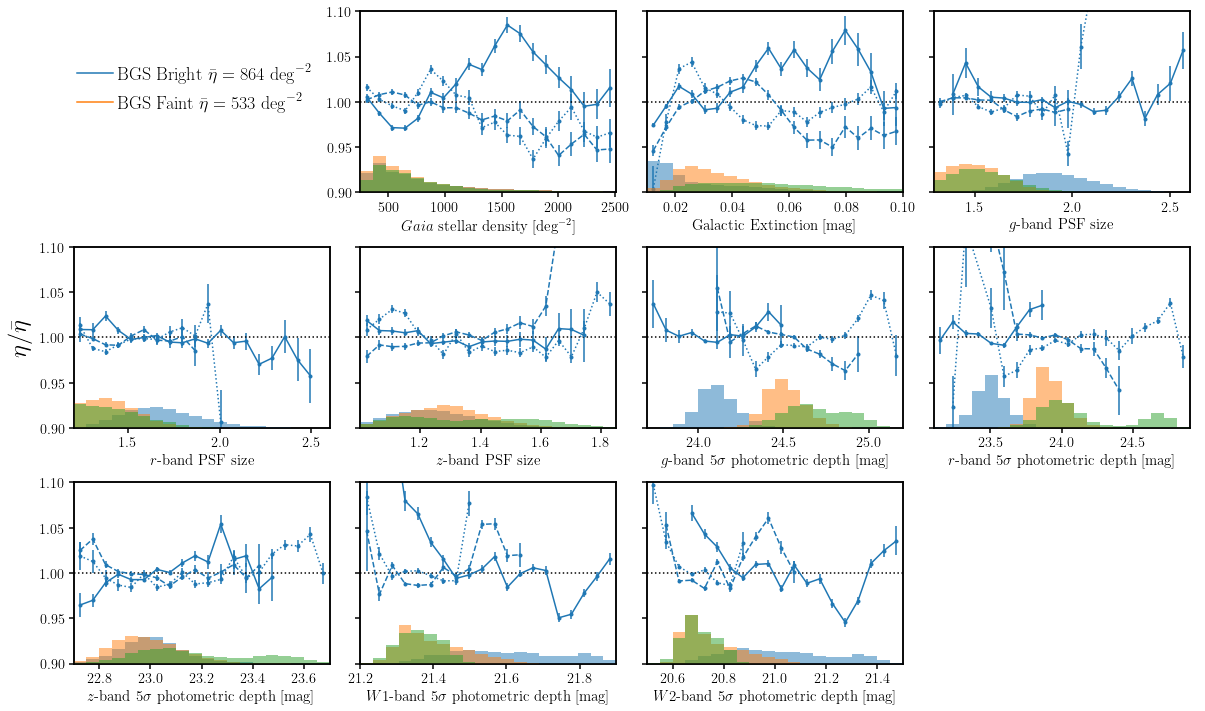

In [108]:
fig = plt.figure(figsize=(20,12))
sub = fig.add_subplot(3,4,1)
sub.plot([], [], c='C0', label=r'BGS Bright $\bar{\eta} = 864$ ${\rm deg}^{-2}$')
sub.plot([], [], c='C1', label=r'BGS Faint $\bar{\eta} = 533$ ${\rm deg}^{-2}$')
sub.legend(bbox_to_anchor=(-0.05, 0.8), loc='upper left', handletextpad=0.2, fontsize=18)
sub.axis('off')

for i, sys in zip(np.arange(len(systematics)), systematics): 
    sub = fig.add_subplot(3,4,i+2)
    sub.axhline(1., color='k', linestyle=':')
    for ii, sample in enumerate(['BRIGHT']): 
        finite = np.isfinite(pix_data[sys])
        
        for footprint, ls in zip([is_bassmzls, is_decals_n, is_decals_s], ['-', '--', ':']): 
            mean_density = np.sum(pix_data['N_BGS_%s' % sample][footprint]) / np.sum(pixarea * pix_data['BGS_FRAC_AREA'][footprint])

            mu_N, sys_edges, _ = binned_statistic(pix_data[sys][footprint & finite], pix_data['N_BGS_%s' % sample][footprint & finite], statistic='sum', range=ranges[i], bins=20)
            mu_area, _, _ = binned_statistic(pix_data[sys][footprint & finite], pixarea * pix_data['BGS_FRAC_AREA'][footprint & finite], statistic='sum', range=ranges[i], bins=20)                                              
            mu_eta = mu_N / mu_area

            finite = np.isfinite(pix_data[sys]) & np.isfinite(pix_data['density_BGS_%s' % sample])

            n_eta, _, _ = binned_statistic(pix_data[sys][footprint & finite], np.ones(np.sum(footprint & finite)), 
                                             statistic='sum', 
                                             range=ranges[i], 
                                             bins=20)
            std_eta, _, _ = binned_statistic(pix_data[sys][footprint & finite], pix_data['density_BGS_%s' % sample][footprint & finite], 
                                             statistic='std', 
                                             range=ranges[i], 
                                             bins=20)
            
            cut = (n_eta > 100) & (mu_area > 0)
            sub.plot(0.5*(sys_edges[1:] + sys_edges[:-1])[cut], mu_eta[cut]/mean_density, c=clrs[ii], ls=ls)
            sub.errorbar(0.5*(sys_edges[1:] + sys_edges[:-1])[cut], mu_eta[cut]/mean_density, yerr=std_eta[cut]/np.sqrt(n_eta[cut])/mean_density, fmt='.C%i' % ii)    
    
    # histogram
    axh = sub.twinx()
    axh.set_xlim(ranges[i])
    axh.set_ylim(0,1)
    axh.axes.get_yaxis().set_ticks([])
    for footprint in [is_bassmzls, is_decals_n, is_decals_s]: 
        axh.hist(pix_data[sys][footprint], bins=sys_edges, weights=np.ones_like(pix_data[sys][footprint]) * 1e-5, alpha=0.5)

    sub.set_xlabel(xlabels[i], fontsize=15)
    sub.set_xlim(ranges[i])
    sub.set_ylim(0.9, 1.1)
    if i not in [0, 3, 7]: 
        sub.set_yticklabels([])
        
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_ylabel(r'$\eta/\bar{\eta}$', labelpad=15, fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.subplots_adjust(wspace=0.12, hspace=0.3)

<ipython-input-107-794a28944985>:19: RuntimeWarning: invalid value encountered in true_divide
  mu_eta = mu_N / mu_area
<ipython-input-107-794a28944985>:19: RuntimeWarning: invalid value encountered in true_divide
  mu_eta = mu_N / mu_area
<ipython-input-107-794a28944985>:19: RuntimeWarning: invalid value encountered in true_divide
  mu_eta = mu_N / mu_area
<ipython-input-107-794a28944985>:19: RuntimeWarning: invalid value encountered in true_divide
  mu_eta = mu_N / mu_area
<ipython-input-107-794a28944985>:19: RuntimeWarning: invalid value encountered in true_divide
  mu_eta = mu_N / mu_area
<ipython-input-107-794a28944985>:19: RuntimeWarning: invalid value encountered in true_divide
  mu_eta = mu_N / mu_area
<ipython-input-107-794a28944985>:19: RuntimeWarning: invalid value encountered in true_divide
  mu_eta = mu_N / mu_area
<ipython-input-107-794a28944985>:19: RuntimeWarning: invalid value encountered in true_divide
  mu_eta = mu_N / mu_area
<ipython-input-107-794a28944985>:19: Run

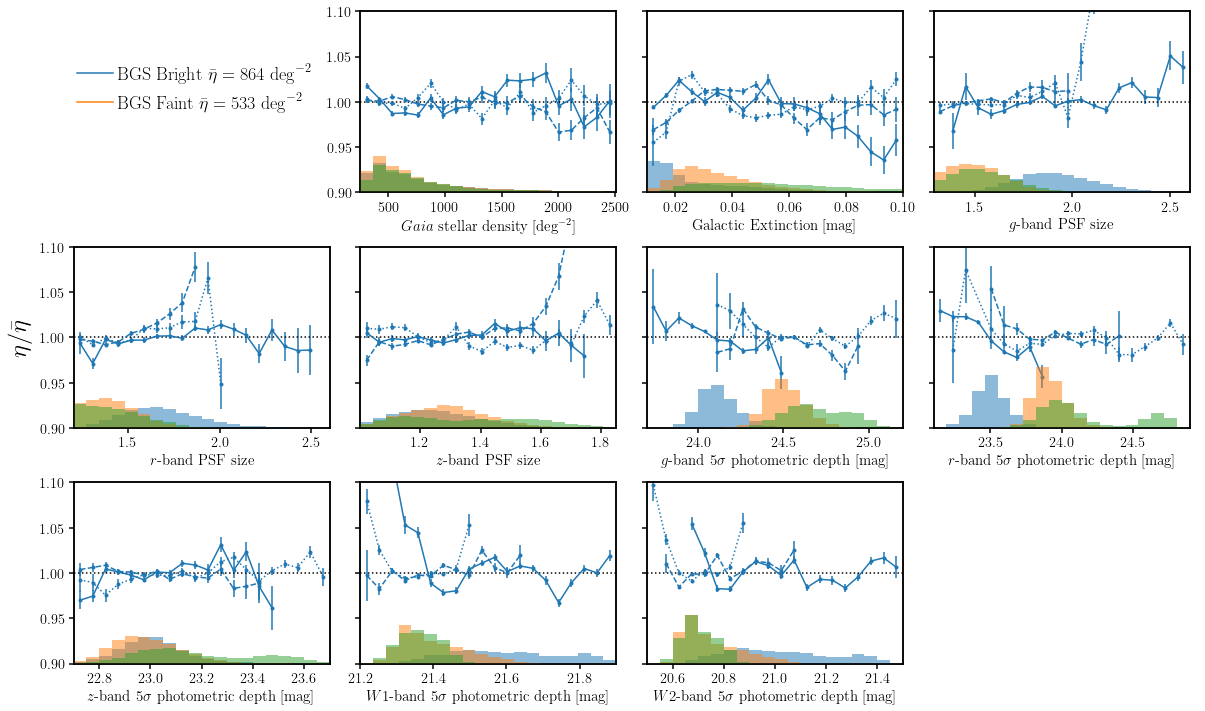

In [107]:
fig = plt.figure(figsize=(20,12))
sub = fig.add_subplot(3,4,1)
sub.plot([], [], c='C0', label=r'BGS Bright $\bar{\eta} = 864$ ${\rm deg}^{-2}$')
sub.plot([], [], c='C1', label=r'BGS Faint $\bar{\eta} = 533$ ${\rm deg}^{-2}$')
sub.legend(bbox_to_anchor=(-0.05, 0.8), loc='upper left', handletextpad=0.2, fontsize=18)
sub.axis('off')

for i, sys in zip(np.arange(len(systematics)), systematics): 
    sub = fig.add_subplot(3,4,i+2)
    sub.axhline(1., color='k', linestyle=':')
    for ii, sample in enumerate(['FAINT']): 
        finite = np.isfinite(pix_data[sys])
        
        for footprint, ls in zip([is_bassmzls, is_decals_n, is_decals_s], ['-', '--', ':']): 
            mean_density = np.sum(pix_data['N_BGS_%s' % sample][footprint]) / np.sum(pixarea * pix_data['BGS_FRAC_AREA'][footprint])

            mu_N, sys_edges, _ = binned_statistic(pix_data[sys][footprint & finite], pix_data['N_BGS_%s' % sample][footprint & finite], statistic='sum', range=ranges[i], bins=20)
            mu_area, _, _ = binned_statistic(pix_data[sys][footprint & finite], pixarea * pix_data['BGS_FRAC_AREA'][footprint & finite], statistic='sum', range=ranges[i], bins=20)                                              
            mu_eta = mu_N / mu_area

            finite = np.isfinite(pix_data[sys]) & np.isfinite(pix_data['density_BGS_%s' % sample])

            n_eta, _, _ = binned_statistic(pix_data[sys][footprint & finite], np.ones(np.sum(footprint & finite)), 
                                             statistic='sum', 
                                             range=ranges[i], 
                                             bins=20)
            std_eta, _, _ = binned_statistic(pix_data[sys][footprint & finite], pix_data['density_BGS_%s' % sample][footprint & finite], 
                                             statistic='std', 
                                             range=ranges[i], 
                                             bins=20)
            
            cut = (n_eta > 100) & (mu_area > 0)
            sub.plot(0.5*(sys_edges[1:] + sys_edges[:-1])[cut], mu_eta[cut]/mean_density, c=clrs[ii], ls=ls)
            sub.errorbar(0.5*(sys_edges[1:] + sys_edges[:-1])[cut], mu_eta[cut]/mean_density, yerr=std_eta[cut]/np.sqrt(n_eta[cut])/mean_density, fmt='.C%i' % ii)    
    
    # histogram
    axh = sub.twinx()
    axh.set_xlim(ranges[i])
    axh.set_ylim(0,1)
    axh.axes.get_yaxis().set_ticks([])
    for footprint in [is_bassmzls, is_decals_n, is_decals_s]: 
        axh.hist(pix_data[sys][footprint], bins=sys_edges, weights=np.ones_like(pix_data[sys][footprint]) * 1e-5, alpha=0.5)

    sub.set_xlabel(xlabels[i], fontsize=15)
    sub.set_xlim(ranges[i])
    sub.set_ylim(0.9, 1.1)
    if i not in [0, 3, 7]: 
        sub.set_yticklabels([])
        
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_ylabel(r'$\eta/\bar{\eta}$', labelpad=15, fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.subplots_adjust(wspace=0.12, hspace=0.3)